<a href="https://colab.research.google.com/github/uptrain-ai/uptrain/blob/main/examples/integrations/vector_db/FAISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="UpTrain">
  </a>
</h1>

<div style="text-align: center;">

# Retrieving Context Documents using FAISS & Evaluating the Quality of Retrieved Context using UpTrain

</div>


## What is a Vector Database?

Vector databases store data as high-dimensional vectors, enabling fast and efficient similarity search and retrieval of data based on their vector representations.

This is particularly useful for large language models (LLMs), which need to process vast amounts of data and find relevant information quickly.

## What is FAISS?

[FAISS](https://github.com/facebookresearch/faiss)  Faiss is a powerful library designed for efficient similarity search and clustering of dense vectors. It offers various algorithms for searching in sets of vectors, even when the data size exceeds the available RAM. Developed primarily at Meta’s Fundamental AI Research group, Faiss provides complete wrappers for Python/numpy and supports GPU implementations for faster performance.

## Why do I need to monitor the retrieval quality?

Let's say a user asks your LLM application a question on refunds, maybe something like: "How can I initiate a refund on my last purchase?". Ideally, the retrieved context should contain two important pieces of information: "the user's last purchase" and "the company's policy on refunds". Now, what if the retrieved context doesn't contain that information or the fetched information is irrelevant. That's where UpTrain comes in, by helping you evaluate the relevance of the retrieved context.

## Overview of this notebooks

In this notebook, we will walk you through some basic applications in RAG, using FAISS as a vector DB for your context documents. Subsequently, we will use UpTrain to evaluate the quality (relevance) of these retrieved contexts. For simplicity, we have divided this notebook into the following 3 parts:

1. **Data Preparation and Embedding:**
   We will begin by processing and embedding our data using a suitable sentence transformer model. This creates high-dimensional vector representations capturing the semantic meaning of each data point.

2. **Vector Search with FAISS:**
   We will then leverage FAISS's efficient vector search capabilities to retrieve relevant results based on a query vector, allowing us to explore the semantic relationships within the data.

3. **UpTrain Evaluation of Retrieved Content:**
   Utilizing UpTrain's pre-built and custom evaluation checks, we will analyze the quality of the retrieved search results. This assessment focuses on aspects such as context relevance, factual accuracy, and response completeness wrt context, providing valuable insights into the effectiveness of the search process.


If you face any difficulties, need some help with using UpTrain or want to brainstorm custom evaluations for your use-case, you can speak to the maintainers of UpTrain [here](https://calendly.com/uptrain-sourabh/30min).


## Step 1 : Install libraries and make necessary imports


**Note:** If you get an error while installing `faiss-gpu`, you can try installing `faiss-cpu` instead.

In [1]:
# !pip install faiss-gpu numpy transformers torch uptrain

In [2]:
import faiss
import numpy as np
import torch
from transformers import BertModel, BertTokenizer
from uptrain import EvalLLM, Evals, APIClient, Settings

## Step 2: Define your document to be embedded

Let's make a semantic search for Sci-Fi books!


In [3]:
documents = [
    {
        "name": "A Gift From The Stars",
        "description": "This is the true story of an abduction and a rescue by benevolent extraterrestrials, various direct contacts Elena Danaan had throughout the years with UFOs and visitors from other worlds.",
        "author": "Elena Dannan",
        "year": 2020,
    },
    {
        "name": "The Time Machine",
        "description": "A man travels through time and witnesses the evolution of humanity.",
        "author": "H.G. Wells",
        "year": 1895,
    },
    {
        "name": "Ender's Game",
        "description": "A young boy is trained to become a military leader in a war against an alien race.",
        "author": "Orson Scott Card",
        "year": 1985,
    },
    {
        "name": "The Royal Abduction",
        "description": "Shreya Singh, a princess from Rajasthan, has been abducted! A woman of beauty and substance, she is living a lavish life. But while there are abundant riches in her palace, there are also dark secrets about her family buried in the past.",
        "author": "Vikram Singh",
        "year": 2023,
    },
]

## Step 3: Choose your embedding model


In [4]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Step 4: Generate embedding and vectorise from the defined text in the previous step


In [5]:
def encode_text(text):
    input_ids = tokenizer.encode(text, return_tensors='pt')
    with torch.no_grad():
        output = model(input_ids)
    return output.pooler_output.numpy()

embeddings = np.vstack([encode_text(doc['description']) for doc in documents])

index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

## Step 5: Define question and fetch relevant information from FAISS


In [6]:
def query_index(question, k=3):
    question_embedding = encode_text(question)
    _, indices = index.search(question_embedding, k)
    return [documents[i] for i in indices[0]]

In [7]:
question = "What are some books that talk about alien abductions?"
results = query_index(question)

Let's have a look at one of the retrieved context documents:

In [8]:
for result in results:
    print(result['name'])
    print(result['description'])

The Time Machine
A man travels through time and witnesses the evolution of humanity.
A Gift From The Stars
This is the true story of an abduction and a rescue by benevolent extraterrestrials, various direct contacts Elena Danaan had throughout the years with UFOs and visitors from other worlds.
Ender's Game
A young boy is trained to become a military leader in a war against an alien race.


In [9]:
data = []
for hit in results:
    data.append(
        {
            "question": question,
            "context": "Book Description for "
            + hit.get("name", "")
            + " : "
            + hit.get("description", ""),
        }
    )

data[0]

{'question': 'What are some books that talk about alien abductions?',
 'context': 'Book Description for The Time Machine : A man travels through time and witnesses the evolution of humanity.'}

## Step 6: Evaluating the retrieved context's quality using UpTrain's Open-Source Software (OSS)


In [10]:
import json

OPENAI_API_KEY = "sk-**********************"  # Insert your OpenAI key here

eval_llm = EvalLLM(
    Settings(openai_api_key=OPENAI_API_KEY, response_format={"type": "json_object"})
)

res = eval_llm.evaluate(data=data, checks=[Evals.CONTEXT_RELEVANCE])

print(json.dumps(res, indent=3))

2024-02-05 12:37:10.025 | INFO     | uptrain.framework.evalllm:evaluate:104 - Sending evaluation request for rows 0 to <50 to the Uptrain


[
   {
      "question": "What are some books that talk about alien abductions?",
      "context": "Book Description for The Time Machine : A man travels through time and witnesses the evolution of humanity.",
      "score_context_relevance": 0.0,
      "explanation_context_relevance": "The extracted context does not contain any information about alien abductions or books related to alien abductions. It only provides a description of a book about time travel and human evolution. Therefore, the selected choice is (C)"
   },
   {
      "question": "What are some books that talk about alien abductions?",
      "context": "Book Description for A Gift From The Stars : This is the true story of an abduction and a rescue by benevolent extraterrestrials, various direct contacts Elena Danaan had throughout the years with UFOs and visitors from other worlds.",
      "score_context_relevance": 1.0,
      "explanation_context_relevance": "The extracted context provides a specific book description 

## [Optional] Step 7: UpTrain Managed Service and Dashboards


You can create a free UpTrain account [here](https://uptrain.ai/) and get free trial credits. If you want more trial credits, [book a call with the maintainers of UpTrain here](https://calendly.com/uptrain-sourabh/30min).


UpTrain Managed service provides:

1. Dashboards with advanced drill-down and filtering options
2. Insights and common topics among failing cases
3. Observability and real-time monitoring of production data
4. Regression testing via seamless integration with your CI/CD pipelines


In [11]:
UPTRAIN_API_KEY = "up-*****************"  # Insert your UpTrain API key here

uptrain_client = APIClient(
    Settings(
        uptrain_access_token=UPTRAIN_API_KEY, response_format={"type": "json_object"}
    )
)

res = uptrain_client.log_and_evaluate(
    "FAISS-context-sample-evals", data, [Evals.CONTEXT_RELEVANCE]
)

print(json.dumps(res, indent=3))

2024-02-05 12:37:11.174 | INFO     | uptrain.framework.remote:log_and_evaluate:610 - Sending evaluation request for rows 0 to <50 to the Uptrain server


[
   {
      "question": "What are some books that talk about alien abductions?",
      "context": "Book Description for The Time Machine : A man travels through time and witnesses the evolution of humanity.",
      "score_context_relevance": 0.0,
      "explanation_context_relevance": "The extracted context does not contain any information about alien abductions or books related to alien abductions. It only provides a description of a book about time travel and human evolution. Therefore, the selected choice is (C)"
   },
   {
      "question": "What are some books that talk about alien abductions?",
      "context": "Book Description for A Gift From The Stars : This is the true story of an abduction and a rescue by benevolent extraterrestrials, various direct contacts Elena Danaan had throughout the years with UFOs and visitors from other worlds.",
      "score_context_relevance": 1.0,
      "explanation_context_relevance": "The extracted context provides a specific book description 

### Dashboards:

Histogram of score vs number of cases with that score

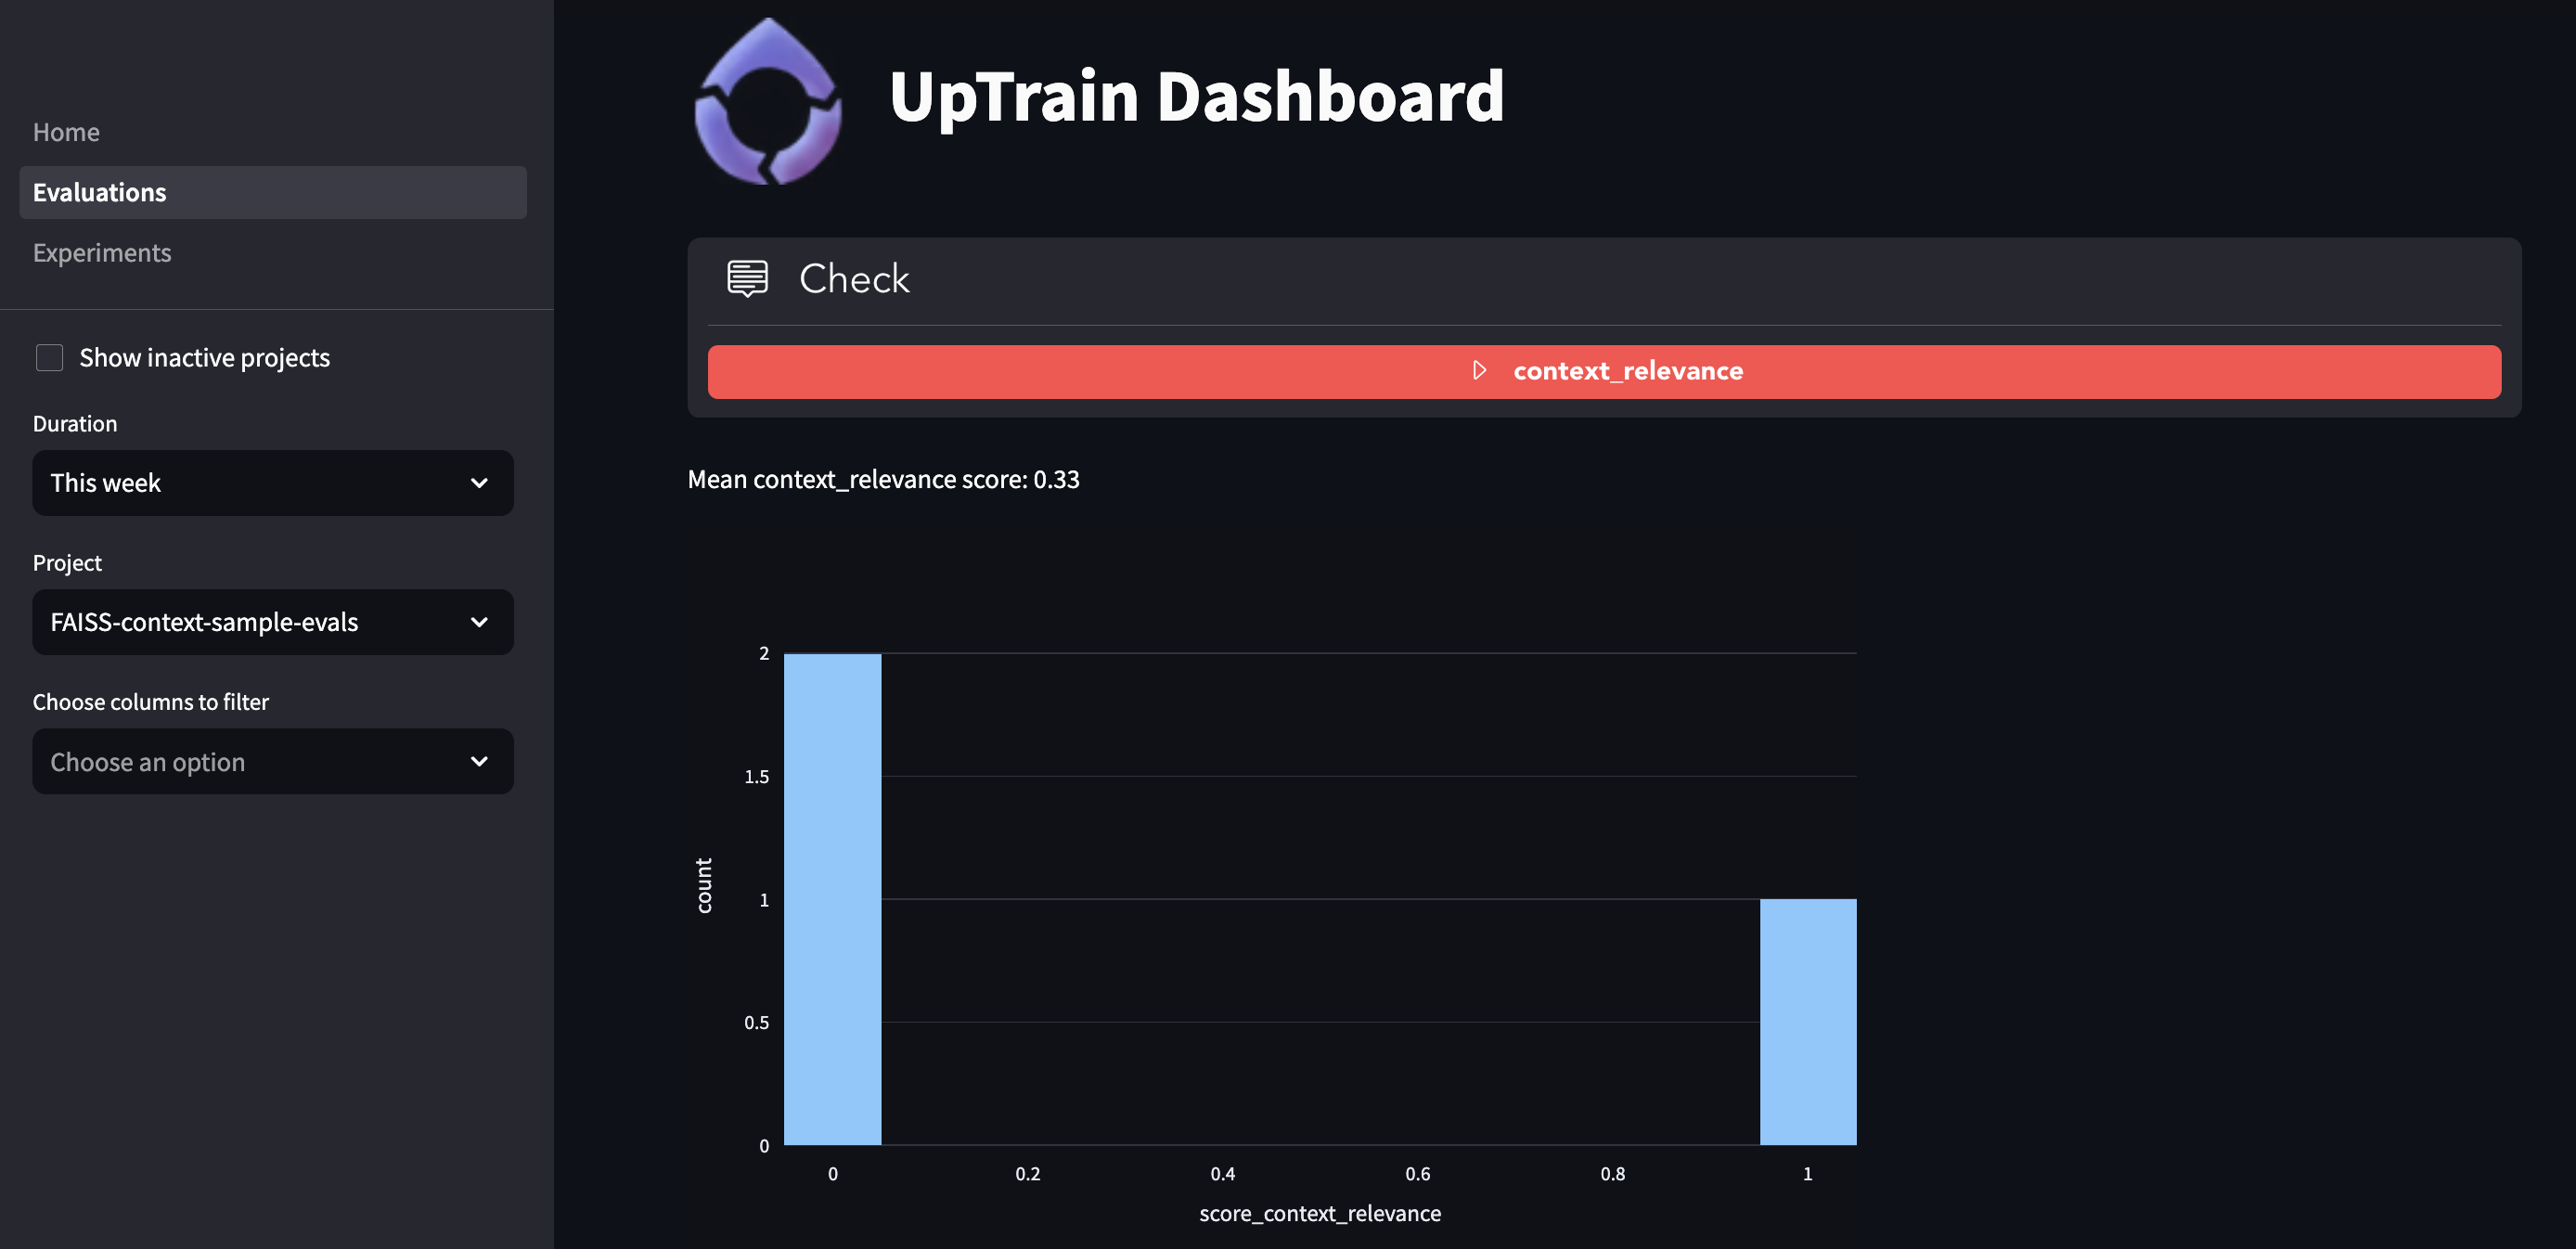

You can access the uptrain dashboards [here](https://demo.uptrain.ai/dashboard/) by using the above defined UPTRAIN_API_KEY


### Insights:

You can filter failure cases and generate common topics among them. This can help identify the core issue and help fix it

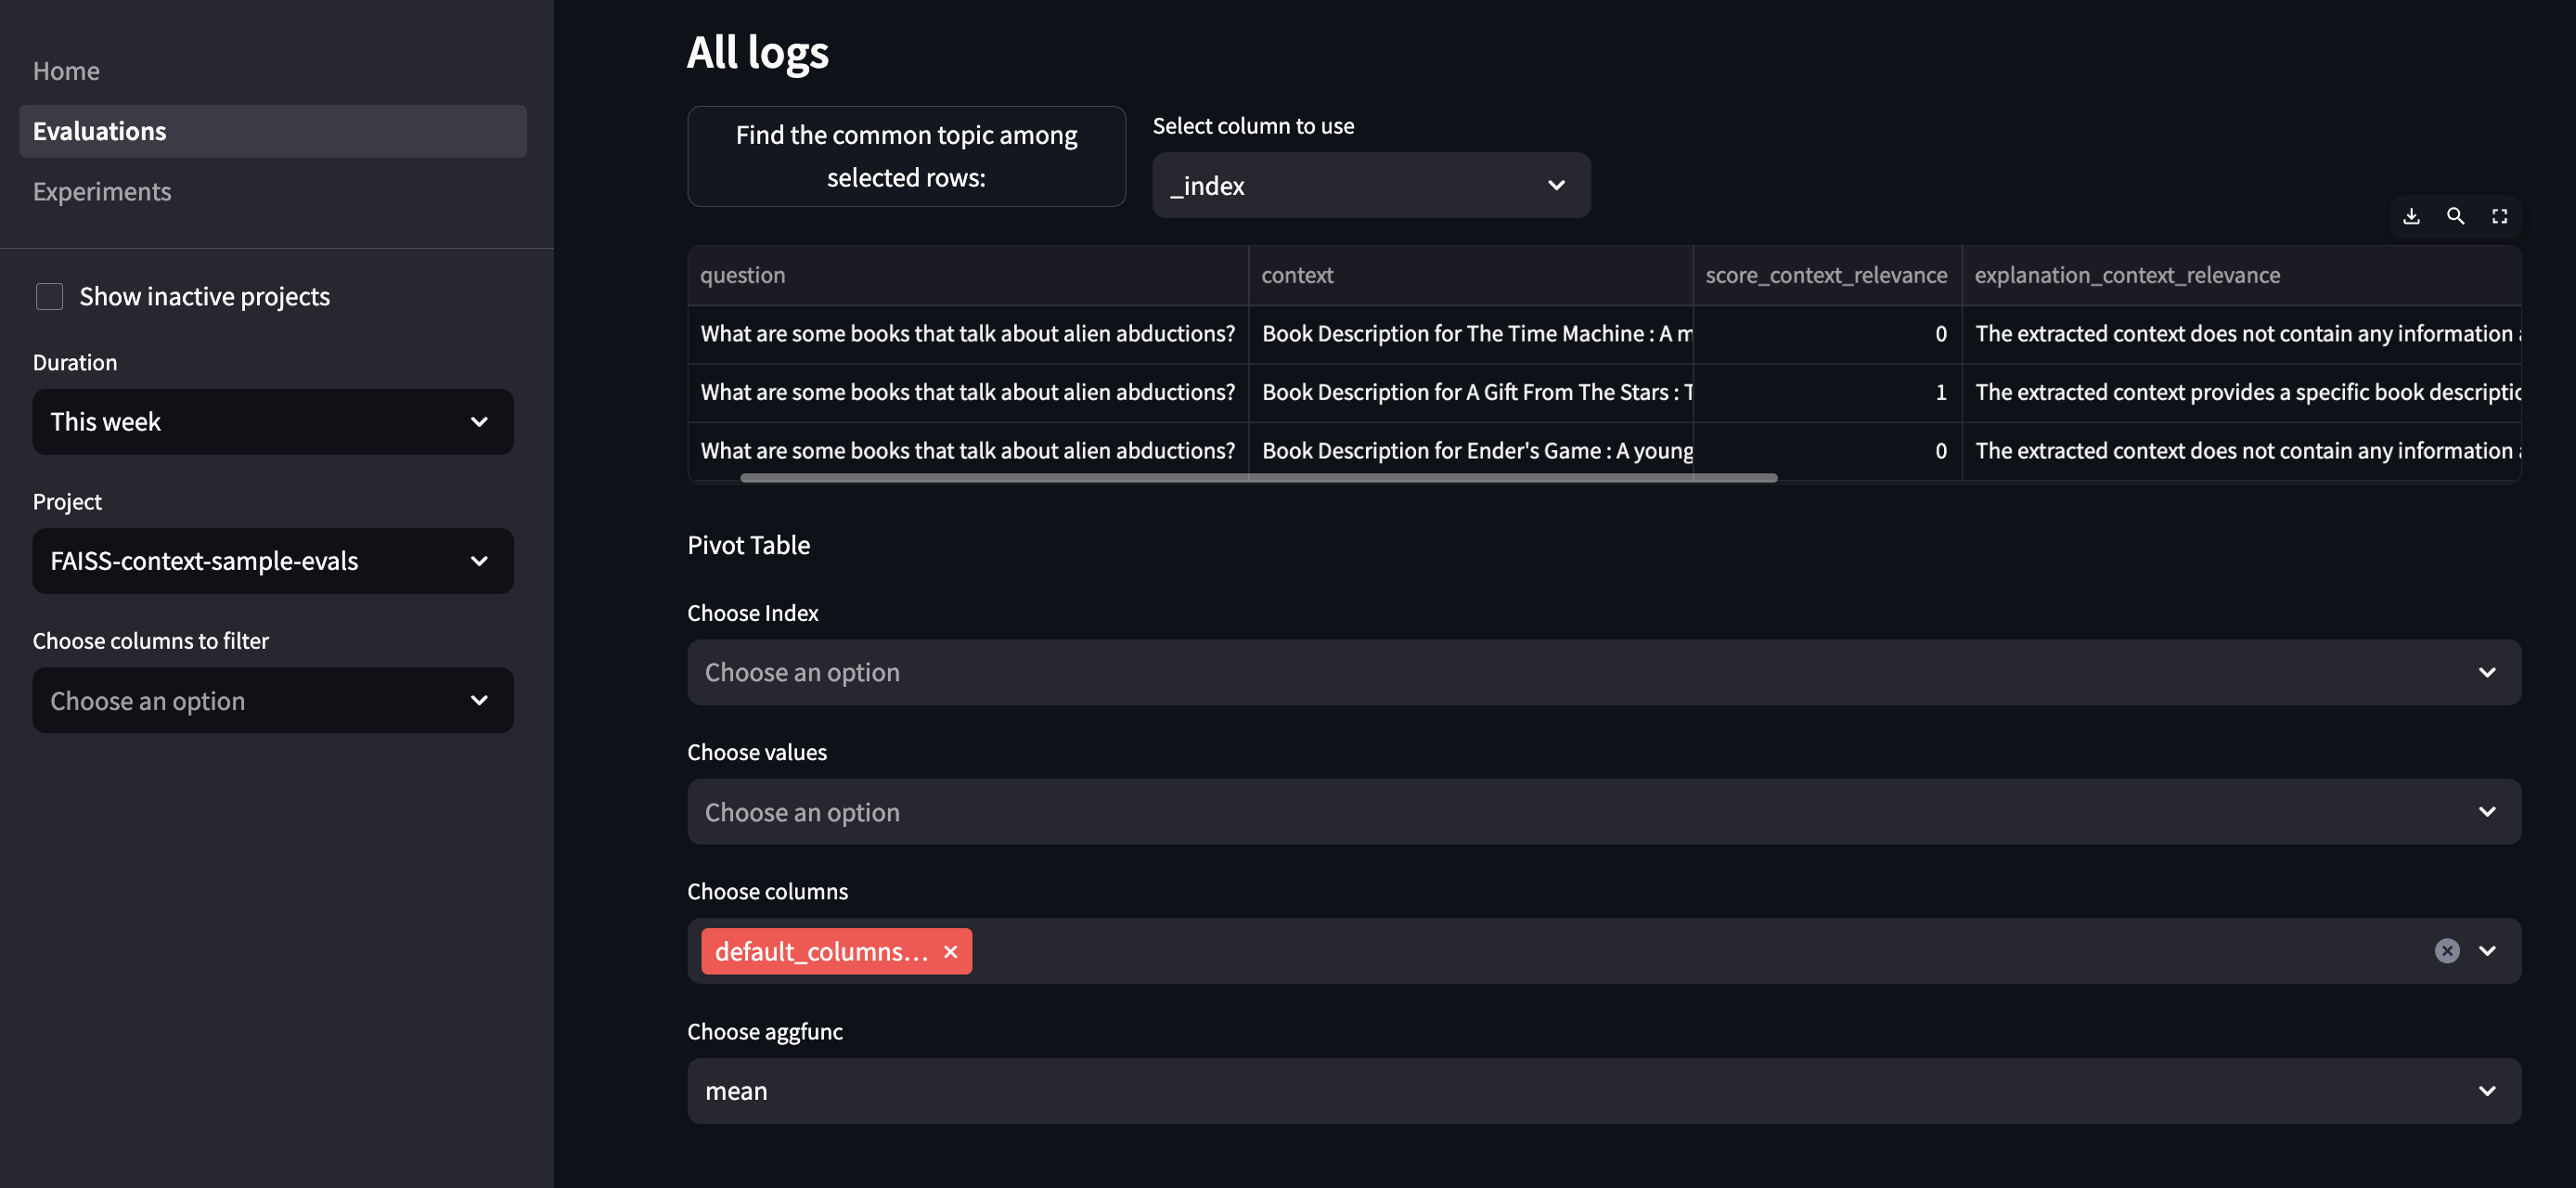